# Baseline MM Analysis

This notebook visualizes baseline simulation output from `outputs/baseline_mm_result.json`.

## How to use this notebook

1. Run `make report` from the repo root to refresh `outputs/baseline_mm_result.json`.
2. Run all cells top-to-bottom.
3. Use this notebook to validate baseline behavior before tuning strategy parameters.

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path('../outputs/baseline_mm_result.json')
if not result_path.exists():
    raise FileNotFoundError(
        'Missing outputs/baseline_mm_result.json. Run `make report` first.'
    )

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

summary = payload['summary']
series = payload['series']
fills = payload['fills']

summary

{'final_pnl': 2.0092885364000495,
 'max_drawdown': -5.844895471196594,
 'sharpe_annualized': 5.2167772609053005,
 'fills': 372.0,
 'fees_paid': -1.1533698313992722,
 'avg_abs_inventory': 2.289843773475984}

## 1) PnL and inventory trajectory

This section checks whether inventory control behaves as expected and whether PnL evolves smoothly without obvious pathologies.

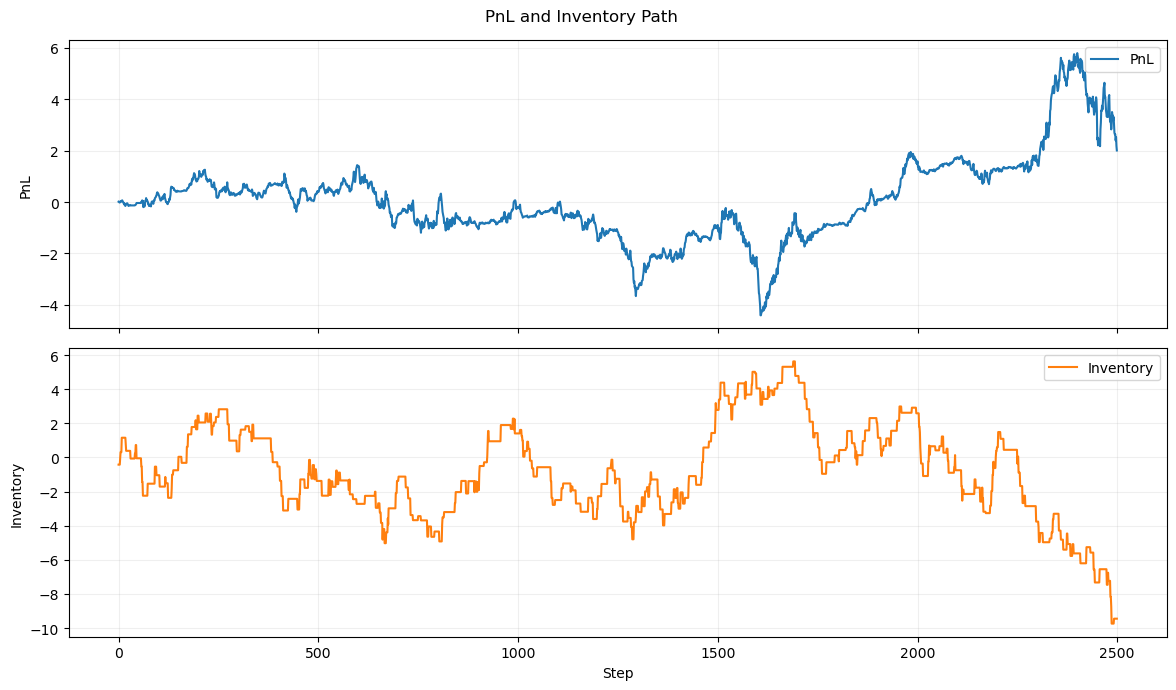

In [2]:
pnl = series['pnl']
inventory = series['inventory']
steps = list(range(len(pnl)))

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(steps, pnl, label='PnL', color='tab:blue')
ax[0].set_ylabel('PnL')
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(steps, inventory, label='Inventory', color='tab:orange')
ax[1].set_ylabel('Inventory')
ax[1].set_xlabel('Step')
ax[1].grid(alpha=0.2)
ax[1].legend()

fig.suptitle('PnL and Inventory Path')
plt.tight_layout()
plt.show()

## 2) Market state backdrop

Plotting mid and spread together gives context for strategy outcomes. If spread is stable while PnL is noisy, execution assumptions likely dominate.

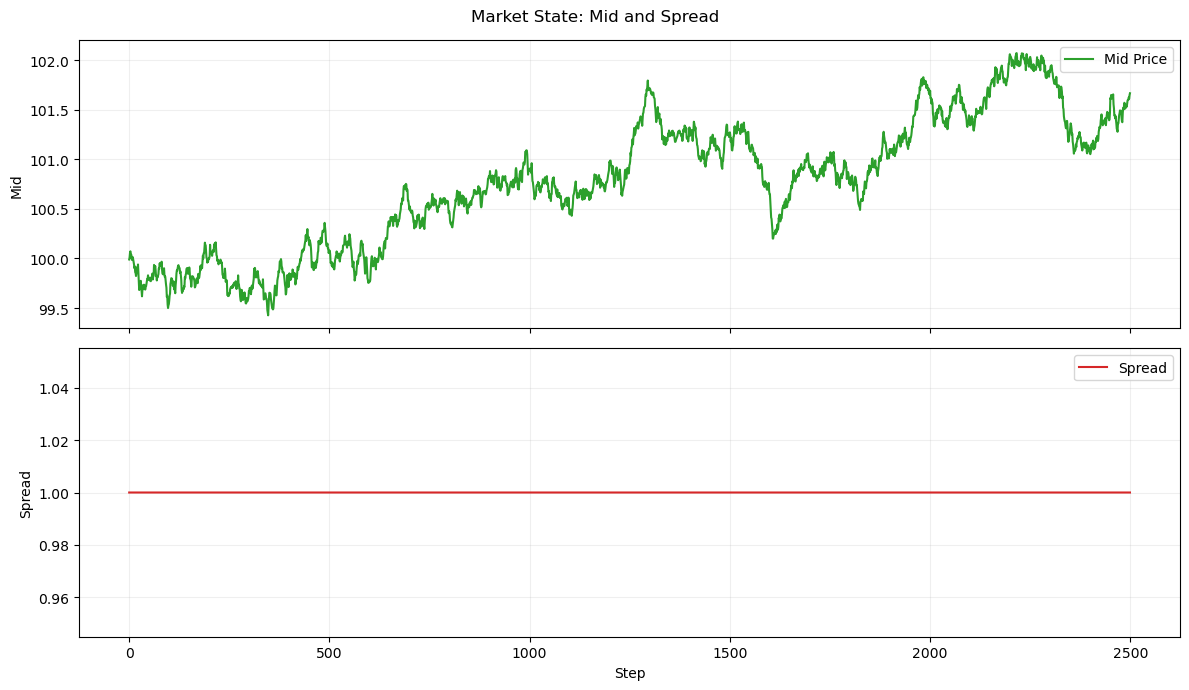

In [3]:
mid = series['mid']
spread = series['spread']
steps = list(range(len(mid)))

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(steps, mid, label='Mid Price', color='tab:green')
ax[0].set_ylabel('Mid')
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(steps, spread, label='Spread', color='tab:red')
ax[1].set_ylabel('Spread')
ax[1].set_xlabel('Step')
ax[1].grid(alpha=0.2)
ax[1].legend()

fig.suptitle('Market State: Mid and Spread')
plt.tight_layout()
plt.show()

## 3) Flow and side participation

Rolling fill counts and notional split indicate whether quoting is balanced or skewed to one side under current parameters.

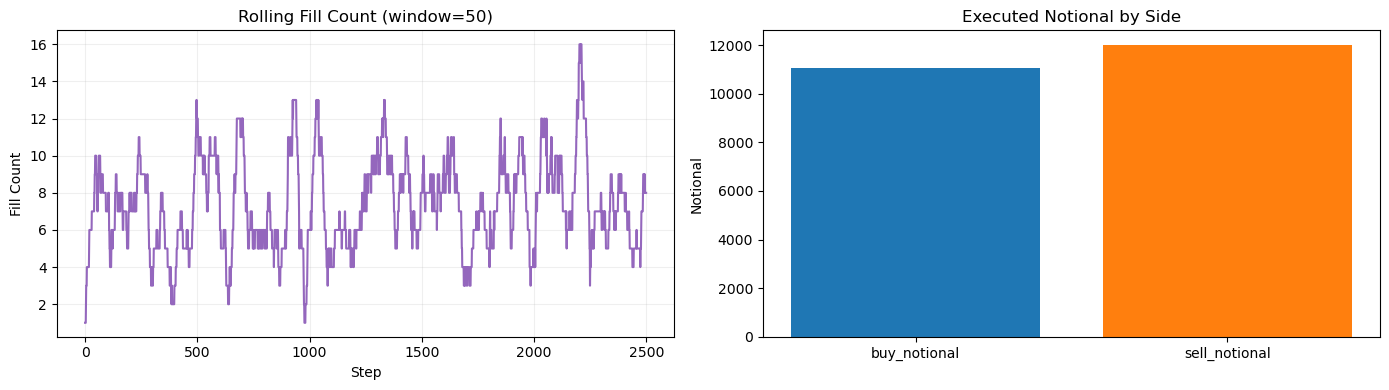

In [4]:
n_steps = len(series['pnl'])
fill_count = [0] * n_steps
buy_notional = 0.0
sell_notional = 0.0

for f in fills:
    step = f['step']
    if 0 <= step < n_steps:
        fill_count[step] += 1
    notional = f['price'] * f['size']
    if f['side'] == 'buy':
        buy_notional += notional
    else:
        sell_notional += notional

window = 50
rolling = []
for i in range(n_steps):
    lo = max(0, i - window + 1)
    rolling.append(sum(fill_count[lo:i+1]))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(range(n_steps), rolling, color='tab:purple')
ax[0].set_title(f'Rolling Fill Count (window={window})')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Fill Count')
ax[0].grid(alpha=0.2)

ax[1].bar(['buy_notional', 'sell_notional'], [buy_notional, sell_notional], color=['tab:blue', 'tab:orange'])
ax[1].set_title('Executed Notional by Side')
ax[1].set_ylabel('Notional')

plt.tight_layout()
plt.show()

## Interpretation checklist

- Large inventory drift with weak PnL usually implies insufficient skew penalty.
- Very low fill activity often means quotes are too conservative for the fill model.
- Strong side imbalance should be cross-checked against spread/imbalance dynamics.